In [1]:
import pandas as pd
import numpy as np
import os
from igraph import Graph, plot
import matplotlib.pyplot as plt
import utils
from collections import Counter, defaultdict
import networkx as nx
import datetime
import skbio
import subprocess

%load_ext autoreload
%aimport utils
%autoreload 1

# Read data and preprocess

In [2]:
TAX_LEVEL = 5
OUTDIR = 'data/18S'

In [3]:
# Read data
df_raw = pd.read_excel('data/18S_AV_OTU_table_wTaxa.xlsx')
meta = pd.read_excel('data/18S_AV_March2019_Metadata.xlsx')
df_raw = df_raw.set_index(['OTU', 'taxonomy'])
df_raw = df_raw[meta['Sample_Names']]
df_raw = df_raw.fillna(0)

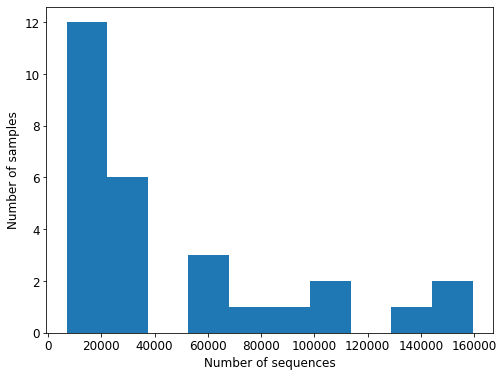

In [4]:
ax = df_raw.sum().plot(kind='hist', figsize=[8, 6], fontsize=12)
ax.set_xlabel('Number of sequences', fontsize=12)
ax.set_ylabel('Number of samples', fontsize=12)
plt.savefig("16s_library_size.png", bbox_inches='tight')

In [5]:
df_filtered = utils.filter_by_abundance(df_raw, .01)
df_filtered = utils.filter_by_prevalence(df_filtered, 13)
df_filtered = df_filtered.reset_index().drop(columns='taxonomy').set_index('OTU')
df_filtered_relative = df_filtered / df_raw.sum()

In [6]:
most_abundance = utils.filter_by_abundance(df_raw, .05)
most_abundance = utils.filter_by_prevalence(most_abundance, 3)
most_abundance_relative = most_abundance / df_raw.sum()
most_abundance_relative = most_abundance_relative.reset_index()
most_abundance_relative['OTU'] = most_abundance_relative['taxonomy'].str.split('; ').apply(lambda x: '; '.join([l.strip('_') for l in x])) + ' (' + most_abundance_relative['OTU'].str.slice(start=6) + ')'
most_abundance_relative.drop(columns='taxonomy', inplace=True)
most_abundance_relative.set_index('OTU', inplace=True)
time = meta.set_index('Sample_Names').loc[most_abundance_relative.columns]['Month'].apply(lambda x: str(datetime.datetime.strptime(x, "%B").strftime("%m")))
most_abundance_relative.columns = time
most_abundance_relative.to_csv('16s_composition.csv') # Export to CSV to create prettier bar chart in google sheets

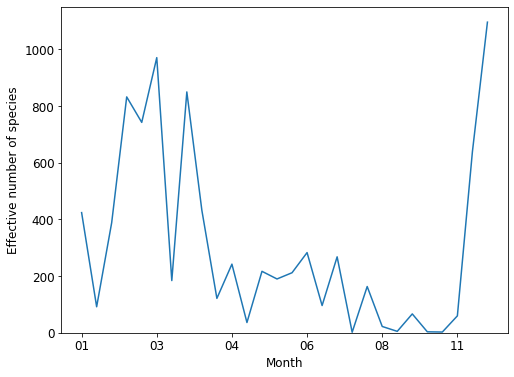

In [7]:
temp = pd.Series(np.exp(skbio.diversity.alpha_diversity('shannon', df_raw.transpose())))
temp.index = time
ax = temp.plot(figsize=(8, 6), fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Effective number of species', fontsize=12)
ax.set_ylim(ymin=0)
plt.savefig('16s_alpha_diversity.png', bbox_inches='tight')

# Build graph

In [8]:
from datetime import datetime
start = datetime.now()
df_cor, df_pval = utils.run_sparcc(df_filtered, OUTDIR, force=True)
(datetime.now() - start).seconds

32

In [9]:
threshold = utils.correct_pvals(df_pval)
print(threshold)
min_pval = df_pval.min().min()
print(min_pval)

0.006
0.001


In [10]:
df_cor[df_pval > max(threshold, min_pval)] = 0

(array([ 109.,   37.,    0.,    0., 2686.,    0.,   13.,  143.,   72.,
          21.]),
 array([-0.657  , -0.49415, -0.3313 , -0.16845, -0.0056 ,  0.15725,
         0.3201 ,  0.48295,  0.6458 ,  0.80865,  0.9715 ]),
 <a list of 10 Patch objects>)

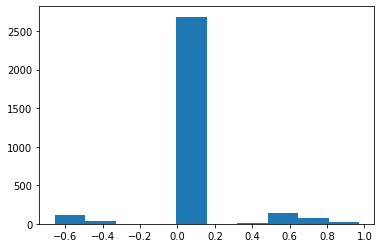

In [11]:
flatten_cor = utils.flatten_square_df(df_cor, k=1)
plt.hist(flatten_cor)

In [12]:
flatten_cor[flatten_cor != 0].describe()

count    395.000000
mean       0.198715
std        0.563412
min       -0.657000
25%       -0.501050
50%        0.520700
75%        0.634300
max        0.971500
dtype: float64

In [13]:
G = nx.from_pandas_adjacency(df_cor)

In [14]:
OTU_to_tax = {OTU:tuple(x.strip('_') for x in tax.split('; ')) for OTU, tax in df_raw.index if OTU in G}

In [15]:
for OTU, tax in OTU_to_tax.items():
    G = nx.relabel_nodes(G, {OTU:tax+(OTU,)})

In [16]:
for node, attrs in G.nodes.items():
    attrs['OTUs'] = 1

In [17]:
utils.merge_nodes_to_level(G, 8, 5)

Original #nodes: 79
Level 8 #nodes: 55
Level 7 #nodes: 42
Level 6 #nodes: 36
Level 5 #nodes: 23


In [18]:
utils.add_node_attrs(G, TAX_LEVEL, df_filtered_relative, OTU_to_tax)
utils.add_edge_attrs(G)

In [19]:
top_connected = [x for x, y in sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]]
top_abundance = sorted(G.nodes, key=lambda n: G.nodes[n]['abundance'], reverse=True)[:5]

for n, attrs in G.nodes.items():
    if n in top_connected and n in top_abundance:
        attrs['color'] = 'orange'
    elif n in top_connected:
        attrs['color'] = 'red'
    elif n in top_abundance:
        attrs['color'] = 'yellow'

In [20]:
nx.write_gml(G, os.path.join(OUTDIR, 'graph.gml'), stringizer=lambda x: '; '.join(x) if type(x)!=str else x)

# Run manta

In [22]:
for i in range(100):
    # manta has a random component and sometimes won't work, keep trying
    try:
        subprocess.run(['manta',
                        '-i', os.path.join(OUTDIR, 'graph.gml'),
                        '-o', os.path.join(OUTDIR, 'graph_manta'),
                        '-ms', '0.0',
                        '-min', '2',
                        '-max', '10',
                        '-f', 'gml',
                        '-subset', '0.8'
                       ],
                       check=True)
        g_manta = Graph.Read_GML(os.path.join(OUTDIR, 'graph_manta.gml'))
        #print(Counter(g_manta.vs['assignment']), Counter(g_manta.vs['cluster']))
        print("clusters ", len(Counter(g_manta.vs['cluster'])))
        break
    except subprocess.CalledProcessError:
        print(i)
        continue

0
1
clusters  2


In [23]:
def assign_color(e):
    if e.source_vertex['cluster'] == e.target_vertex['cluster']:
        return 'green' if e['weight'] >= 0 else 'red'
    else:
        return 'blue' if e['weight'] >= 0 else 'orange'
g_manta.es['color'] = list(map(assign_color, g_manta.es))

In [24]:
g_manta.write_gml(os.path.join(OUTDIR, 'graph_cytoscape.gml'))

# Env vars

In [25]:
g_cyto = nx.read_gml(os.path.join(OUTDIR, 'graph_cytoscape.gml'))

In [26]:
env_vars = meta.set_index('Sample_Names').loc[df_filtered_relative.columns][['Temp_C', 'Salinity', 'Chlorophyll_ugL']]
for env_var in env_vars:
    env_cor = utils.calc_spearman_cor(df_filtered_relative, env_vars[env_var])
    utils.add_env_node(g_cyto, env_cor, OTU_to_tax)

/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
nx.write_gml(g_cyto, os.path.join(OUTDIR, 'graph_cytoscape.gml'))